# Convolution and the Spectral Division

Here we try to evaluate the problems of performing the spectral division as a way to invert the convolution with a given PSF 

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import filters

from scipy import signal
%matplotlib inline

We need to load a default image to play with. We take a few image examples provided by the skimage library.

In [16]:
# we load a standard image
camera = data.camera()
camera = data.shepp_logan_phantom()

# intensity normalization
camera = np.float64(camera[1:,1:])
camera /= camera.max()

Successively, we need to define a PSF that will blur the image.
First, we dicide how big is the kernel that we want (better an odd number of pixels), we locate the center and we set 1 in there. This corresponds to an ideal delta response of the system. 

Then, we blur the response of the system with a Gaussian filter. We do this for simplicity, but you could have done the same by defining a 2D Gaussian function with a centered maximum and obtain the same results.

In [17]:
# kernel size and properties
kernelsize = camera.shape[0]
center = np.uint32(np.floor(kernelsize/2.))

# ideal system response
delta = np.zeros([kernelsize,kernelsize])
delta[center,center] = 1

# Gaussian optical response
psf = filters.gaussian(delta, sigma=5)

We blur the object by performing a spectral product as in:
$$ I = \mathcal{F}^{-1} \left\{ \mathcal{F}\{ O \} \cdot \mathcal{F}\{ K \} \right\} $$

In [18]:
# we filter the image in Fourier domain
camera_blurred = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.fft2(camera)*np.fft.fft2(psf))))

It is now time to define our "deconvolution" function that performs the spectral division.
The idea is to Fourier transform both the blurred measure and the PSF, then performing the division and then invert back to the object space. 

$$ O = \mathcal{F}^{-1} \left\{ \frac{\mathcal{F}\{ I \}}{\mathcal{F}\{ K \}}      \right\} $$

In [19]:
def spectraldivision(blurred, psf):
    F_blurred = np.fft.fft2(blurred)
    F_psf = np.fft.fft2(psf)
    
    F_spectraldivision = F_blurred / F_psf
    deblurred = np.abs(np.fft.fftshift(np.fft.ifft2(F_spectraldivision)))
    
    return deblurred

We use it...

In [20]:
camera_spectraldiv = spectraldivision(camera_blurred, psf)

And we plot the results...

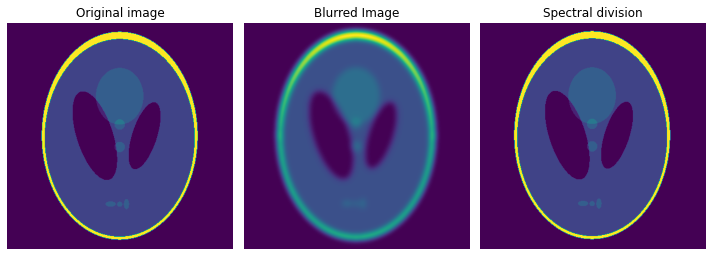

In [21]:
plt.figure(figsize=[10,10])
plt.subplot(131), plt.imshow(camera), plt.axis('off'), plt.title('Original image')
plt.subplot(132), plt.imshow(camera_blurred), plt.axis('off'), plt.title('Blurred Image')
plt.subplot(133), plt.imshow(camera_spectraldiv), plt.axis('off'), plt.title('Spectral division')
plt.tight_layout()

It worked, right!

But what are we missing here? The noise of course... So, here we test the same function used on a blurred measurement corrupted by just a little bit of random (flat) noise...

$$ O = \mathcal{F}^{-1} \left\{ \frac{\mathcal{F}\{ I \} - \mathcal{F}\{ \varepsilon \}  }{\mathcal{F}\{ K \}}      \right\} $$

In [22]:
# make random noise
alpha = 1e-11
noise = np.random.rand(camera.shape[0], camera.shape[1])

# add it to the blurred object
camera_blurred_noisy = camera_blurred + alpha * noise

And we run the spectral division again:

In [23]:
camera_spectraldiv = spectraldivision(camera_blurred_noisy, psf)

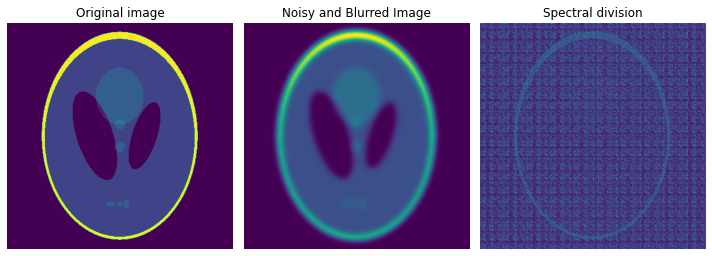

In [24]:
plt.figure(figsize=[10,10])
plt.subplot(131), plt.imshow(camera), plt.axis('off'), plt.title('Original image')
plt.subplot(132), plt.imshow(camera_blurred_noisy), plt.axis('off'), plt.title('Noisy and Blurred Image')
plt.subplot(133), plt.imshow(camera_spectraldiv), plt.axis('off'), plt.title('Spectral division')
plt.tight_layout()

And it doesn't work anymore! 

If you play around, for $\alpha = 10^{12} $ and lower, you'll start to recover somehow the object. However, that is going to be an incredibly low amount of noise and it does not represent any laboratory conditions.

Instead, for any value $\alpha > 10^{11} $ you won't reconstruct anything but noise.